In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from figure_labeler import *

from IPython.display import HTML
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
fl = FigureLabeler();
pd.options.mode.chained_assignment = None

<h1 style="text-align:center;">Optimizing Ad Bidding Strategies: Analyzing Facebook's A/B Test with Predictive Modeling</h1>
<hr>

<a name="top"></a>
#### Table of Contents:

[ref0]: #exec_summary
- [Executive Summary][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref2]: #motiv
- [Motivation][ref2]

[ref3]: #dat_sor
- [Data Source][ref3]

[ref4]: #dat_prep
- [Data Preprocessing][ref4]

[ref5]: #dat_expl
- [Data Exploration][ref5]

[ref6]: #res_dis
- [Results and Discussions][ref6]

[ref7]: #conc
- [Conclusion and Recommendations][ref7]

[ref8]: #refe
- [References][ref8]

***

<a name="exec_summary"></a>
## Executive Summary
In this section, we present an overview of the analysis performed on the dataset, which captures the effectiveness of different advertising strategies through an A/B test.
***

In the competitive landscape of digital advertising, businesses are increasingly leveraging data to enhance their advertising strategies and maximize their return on investment (ROI). The dataset at hand provides a comprehensive view of ad campaign performance through an A/B test, where two groups—test and control—are analyzed to understand the impact of different advertising strategies. Each dataset includes key metrics: impressions (the frequency with which ads are displayed), clicks (the frequency with which ads are clicked), purchases (the number of products bought following a click), and earnings (the revenue generated from these purchases).

In this analysis, we employ multiple machine learning models to predict the log-transformed earnings based on impressions, clicks, and purchases. The models used include Linear Regression, Decision Tree Regressor, and Gradient Boosted Trees (GBT) Regressor. By scaling and polynomially expanding the features, we aim to enhance model performance. Evaluation metrics such as Root Mean Squared Error (RMSE) and R-squared (R2) are utilized to gauge model accuracy and fit.

Visualizations of model predictions against actual earnings, along with residual plots, provide insights into the performance of each model, revealing areas of strength and potential improvements. This analysis helps in understanding the effectiveness of different ad campaigns and guides strategic decisions for optimizing future ad spends.

[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
## Problem Statement
In this section, we define the problem of predicting ad campaign earnings based on key metrics.
***

The primary objective of this project is to develop predictive models to estimate earnings based on these metrics. To accomplish this, the data will be preprocessed using feature engineering techniques such as polynomial expansion and scaling, and several regression models—Linear Regression, Decision Tree Regressor, and Gradient Boosted Trees Regressor—will be trained. The performance of these models will be evaluated using metrics like Root Mean Squared Error (RMSE) and R-squared (R2), allowing for a comparison of their predictive accuracy and effectiveness. By interpreting the results and visualizations from these models, the analysis aims to provide actionable insights that can guide future ad campaign strategies, ultimately enhancing campaign effectiveness and maximizing ROI.

[ref]: #top
[Back to Table of Contents][ref]

<a name="motiv"></a>
## Motivation
In this section, we explain the importance of optimizing ad campaigns and how predictive modeling can enhance the effectiveness of advertising strategies.
***

By analyzing ad performance data, businesses can make informed decisions about where to allocate their ad budgets and how to tailor their advertising strategies for better results. The motivation behind this analysis is to leverage machine learning models to uncover insights that can lead to more efficient ad spending and improved ROI.

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_sor"></a>
## Data Source
In this section, the data source of the study is indicated.
***

The analysis of the dataset titled *"Optimizing ad bidding: Facebook’s A/B test story"* by D. Yılmaz involves an A/B test comparing two bidding strategies on Facebook ads: "average bidding" and "maximum bidding." The dataset includes key metrics such as impressions, clicks, purchases, and earnings over a 40-day period. The goal is to determine which bidding strategy is more effective in terms of ad performance.

*Click this for the dataset:* [Dataset Link](https://www.kaggle.com/datasets/furth3r/facebook-ab-test-of-bidding-feature?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR0KSdhxJak6zem52GtLSLJP_Oys5-Zcx1PzaAekiI5rEtKMKjJhxIpv9j0_aem_lXHvjwx2kc2eSm7Zwmp92g)

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_prep"></a>
## Data Preprocessing
***

In this section, PySpark is set up and the datasets are loaded. Initial data cleaning steps are then performed to ensure data quality and completeness.

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .appName('AdCampaignEarningsPrediction')
        .getOrCreate()
)

In [4]:
control_df = spark.read.csv('control_group.csv', 
                            header=True, 
                            inferSchema=True)
test_df = spark.read.csv('test_group.csv', 
                         header=True, 
                         inferSchema=True)

In [5]:
fl.table_caption("Control DataFrame Overview",
                 "This table shows the data contained in the Control DataFrame, including all relevant columns(Impression, Click, Purchase, and Earning).")

control_df.show()

+----------+-----+--------+-------+
|Impression|Click|Purchase|Earning|
+----------+-----+--------+-------+
|     82529| 6090|     665|   2311|
|     98050| 3383|     315|   1743|
|     82696| 4168|     458|   1798|
|    109914| 4911|     487|   1696|
|    108458| 5988|     441|   1544|
|     77774| 4462|     520|   2082|
|     95111| 3556|     513|   1815|
|    106649| 4358|     747|   1965|
|    122710| 5092|     746|   1652|
|     79498| 6654|     471|   2456|
|     83677| 4273|     386|   2174|
|    132781| 5830|     629|   1992|
|     87939| 3993|     614|   1655|
|    117827| 5560|     740|   1985|
|    129147| 5538|     458|   1601|
|    101616| 5324|     802|   2182|
|     45476| 7370|     400|   1254|
|    147539| 3857|     329|   2144|
|     82068| 6609|     267|   1792|
|     81873| 7959|     729|   1332|
+----------+-----+--------+-------+
only showing top 20 rows



In [6]:
fl.table_caption("Test DataFrame Overview",
                 "his table displays the data from the Test DataFrame, including all relevant columns and their corresponding values.")

test_df.show()

+----------+-----+--------+-------+
|Impression|Click|Purchase|Earning|
+----------+-----+--------+-------+
|    120104| 3217|     702|   1940|
|    134776| 3635|     834|   2929|
|    107807| 3057|     423|   2526|
|    116445| 4650|     429|   2281|
|    145083| 5201|     750|   2782|
|    115923| 4214|     778|   2157|
|    106116| 3279|     492|   2560|
|    125957| 4691|     856|   2564|
|    117443| 3908|     660|   2242|
|    131272| 4721|     532|   2368|
|     96331| 3861|     890|   2613|
|    123799| 3938|     524|   2221|
|    157681| 4468|     702|   3171|
|    117282| 2618|     372|   1948|
|    119878| 3623|     689|   2812|
|    137222| 4042|     677|   2260|
|    134387| 4986|     418|   2088|
|     83357| 6020|     570|   2538|
|    115935| 5060|     653|   2683|
|    115304| 4096|     454|   2300|
+----------+-----+--------+-------+
only showing top 20 rows



In [7]:
for column in control_df.columns:
    null_count = control_df.filter(col(column).isNull()).count()
    print(f"control_df {column}: {null_count}")

control_df Impression: 0
control_df Click: 0
control_df Purchase: 0
control_df Earning: 0


In [8]:
for column in test_df.columns:
    null_count = test_df.filter(col(column).isNull()).count()
    print(f"test_df {column}: {null_count}")

test_df Impression: 0
test_df Click: 0
test_df Purchase: 0
test_df Earning: 0


In [9]:
fl.table_caption("Summary Statistics for Control DataFrame",
                 "This table provides summary statistics for the Control DataFrame, including count, mean, standard deviation, minimum, and maximum values for each numeric column.")

control_df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|       Impression|             Click|          Purchase|          Earning|
+-------+-----------------+------------------+------------------+-----------------+
|  count|               40|                40|                40|               40|
|   mean|        101711.45|          5100.625|             550.9|         1908.575|
| stddev|20302.12298353208|1329.9577723679993|134.11051699710492|302.8683294766886|
|    min|            45476|              2190|               267|             1254|
|    max|           147539|              7959|               802|             2497|
+-------+-----------------+------------------+------------------+-----------------+



In [10]:
fl.table_caption("Summary Statistics for Test DataFrame",
                 "This table presents the summary statistics for the Test DataFrame, including metrics such as count, mean, standard deviation, minimum, and maximum values for each numeric column.")

test_df.describe().show()

+-------+-----------------+-----------------+----------------+------------------+
|summary|       Impression|            Click|        Purchase|           Earning|
+-------+-----------------+-----------------+----------------+------------------+
|  count|               40|               40|              40|                40|
|   mean|       120512.425|          3967.55|          582.05|          2514.925|
| stddev|18807.46661586965|923.0717656907206|161.175163512662|282.70791191888935|
|    min|            79034|             1837|             312|              1940|
|    max|           158606|             6020|             890|              3171|
+-------+-----------------+-----------------+----------------+------------------+



<a name="dat_expl"></a>
## Data Exploration
***

In this section, analyze and visualize the data to understand patterns and relationships related to player attributes and performance.

In [11]:
control_pd = control_df.toPandas()
test_pd = test_df.toPandas()
sns.set(style="whitegrid")

<Figure size 1000x800 with 0 Axes>

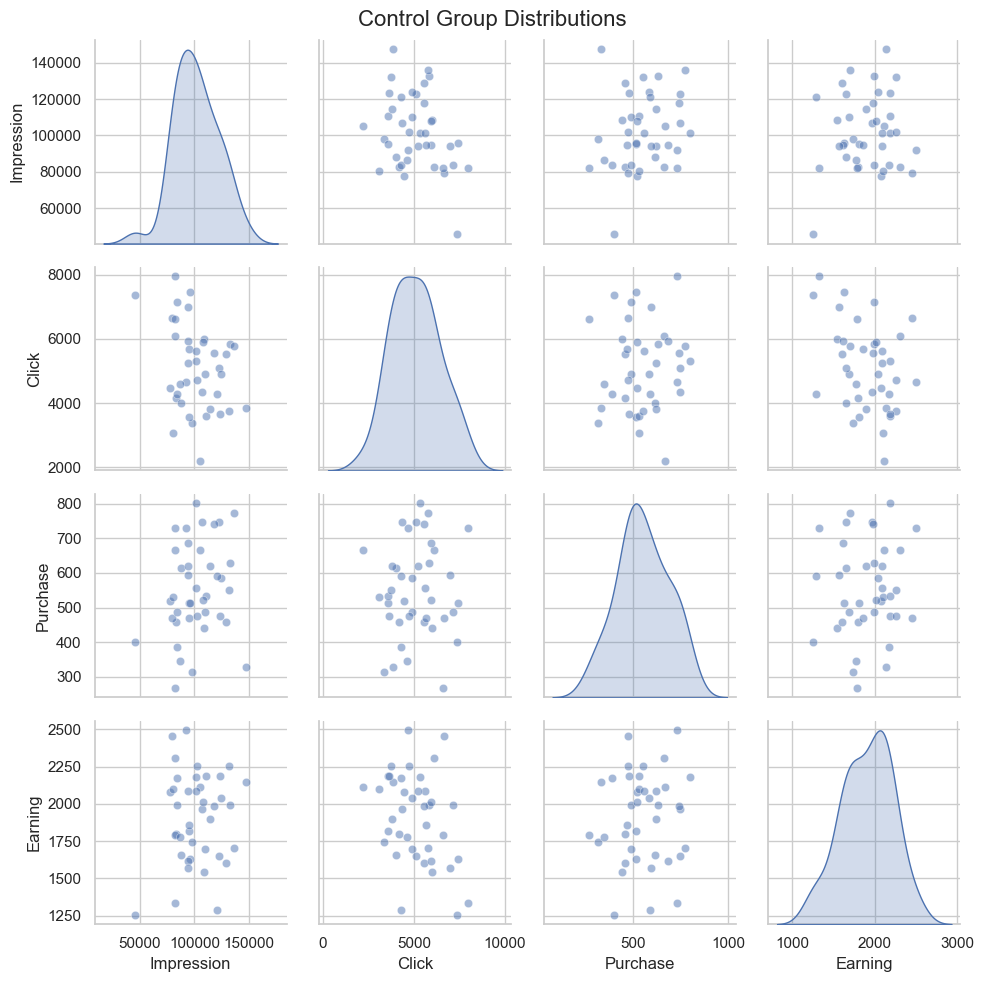

In [12]:
plt.figure(figsize=(10, 8))
pairplot_control = sns.pairplot(control_pd, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})
pairplot_control.fig.suptitle('Control Group Distributions', fontsize=16)
pairplot_control.fig.tight_layout()
pairplot_control.fig.subplots_adjust(top=0.95) 
plt.show()

fl.fig_caption("Distributions of Control Group Variables",
               "This figure shows the pairwise distributions and relationships among variables in the Control Group. The diagonal plots display Kernel Density Estimates (KDEs), while the off-diagonal plots illustrate scatter plots, providing insights into variable distributions and correlations.")

The figure is a pair plot showing the distributions and relationships between four variables in a control group: Impression, Click, Purchase, and Earning. The diagonal plots show individual distributions: Impression peaks around 100,000, Click is centered around 5,000, Purchase around 500, and Earning around 1,750. Scatter plots in the off-diagonal cells depict the relationships between these variables. Impression vs. Click, Impression vs. Purchase, and Impression vs. Earning scatter plots indicate weak or no linear correlations due to the scattered points. Click vs. Purchase and Click vs. Earning also show no clear pattern. However, Purchase vs. Earning displays a slight upward trend, suggesting a potential positive correlation. This implies that while the number of impressions and clicks do not strongly influence earnings, the number of purchases shows a more direct relationship with earnings. This pair plot effectively highlights both the distributions and relationships among the variables in a control group, aiding in exploratory data analysis and suggesting that purchases may be a more critical metric for driving earnings than impressions or clicks alone.

<Figure size 1000x800 with 0 Axes>

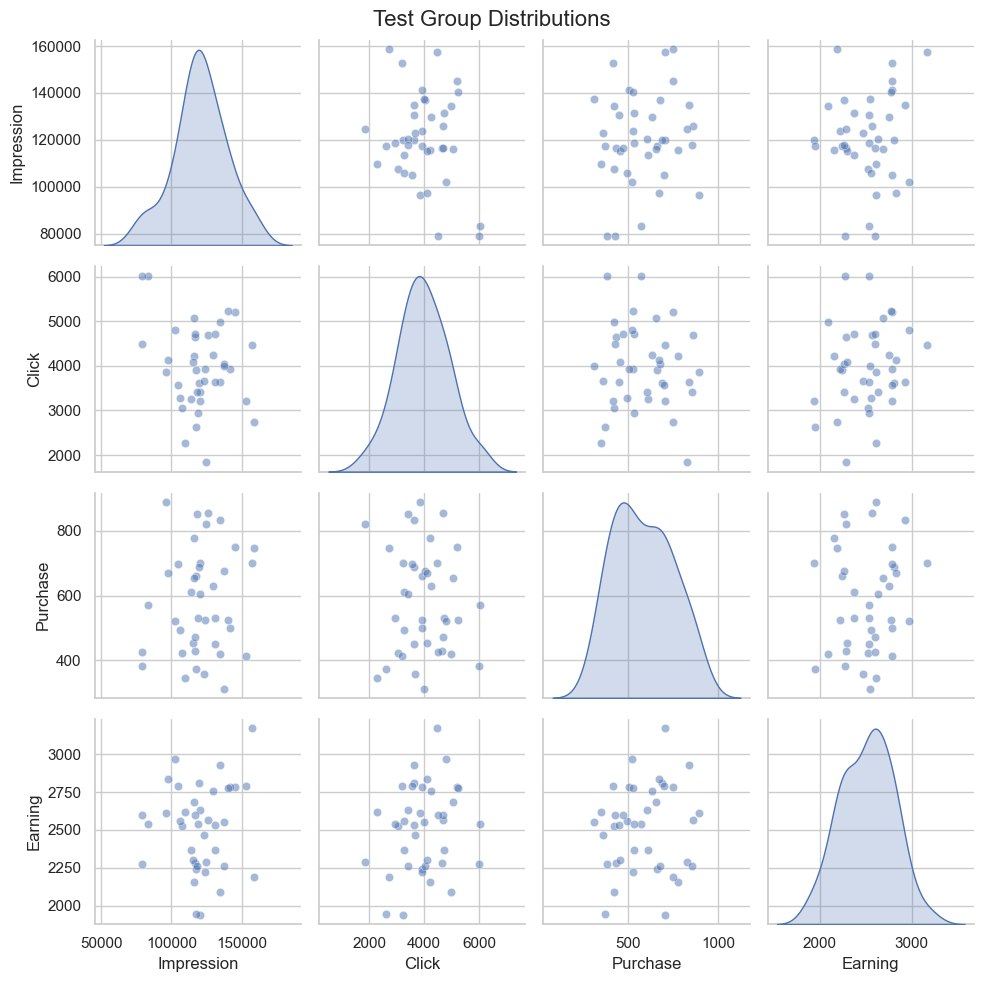

In [13]:
plt.figure(figsize=(10, 8))
pairplot_test = sns.pairplot(test_pd, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})
pairplot_test.fig.suptitle('Test Group Distributions', fontsize=16)
pairplot_test.fig.tight_layout()
pairplot_test.fig.subplots_adjust(top=0.95)  

fl.fig_caption("Distributions of Test Group Variables",
               "This figure illustrates the pairwise distributions and relationships among variables in the Test Group. The diagonal plots show Kernel Density Estimates (KDEs), and the off-diagonal plots display scatter plots, highlighting variable distributions and correlations.")

The pair plot for the test group displays the distributions and relationships between four key variables: impressions, clicks, purchases, and earnings. The diagonal plots reveal that impressions peak around 140,000, clicks center around 4,000, purchases around 500, and earnings peak around 2,750. The scatter plots illustrate the relationships between these variables. For instance, the impressions vs. clicks, impressions vs. purchases, and impressions vs. earnings scatter plots show weak or no linear correlations, suggesting that increasing impressions alone does not significantly impact clicks, purchases, or earnings. Similarly, the clicks vs. purchases and clicks vs. earnings plots exhibit no clear trends. However, the purchases vs. earnings plot indicates a slight upward trend, implying a potential positive correlation where higher purchases might be associated with higher earnings. This means that strategies aimed at increasing purchases could be more effective in boosting earnings than simply increasing impressions or clicks.

In [14]:
control_corr = control_pd.corr()
test_corr = test_pd.corr()

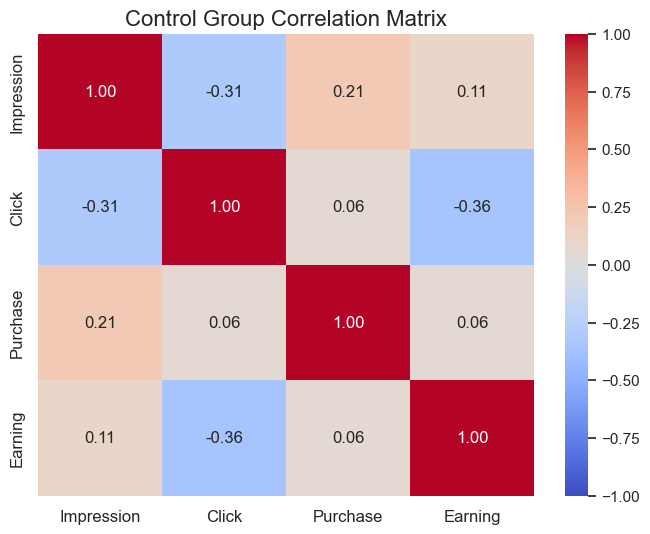

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(control_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12}, fmt='.2f')
plt.title('Control Group Correlation Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fl.fig_caption("Control Group Correlation Matrix",
               "This heatmap displays the correlation matrix for the Control Group, showing the pairwise correlation coefficients between variables. The color gradient represents the strength of the correlations, with annotations indicating the exact correlation values.")

The correlation matrix for the control group shows that Impression has weak positive correlations with Purchase (0.21) and Earning (0.11), and a moderate negative correlation with Click (-0.31). Click, on the other hand, has very weak positive correlations with Purchase (0.06) and a moderate negative correlation with Earning (-0.36). Purchase displays very weak correlations with both Click (0.06) and Earning (0.06). Earning has weak positive correlations with Impression (0.11) and Purchase (0.06), and a moderate negative correlation with Click (-0.36). This indicates that while increasing impressions might slightly boost purchases and earnings, clicks do not significantly translate into purchases or earnings. Consequently, impressions could be a more effective metric to focus on for improving ad performance in the control group. This suggests that the current strategy might be better optimized by emphasizing factors that drive impressions, as these appear to have a more direct, albeit weak, impact on earnings and purchases compared to clicks, which show less influence on the final outcomes.

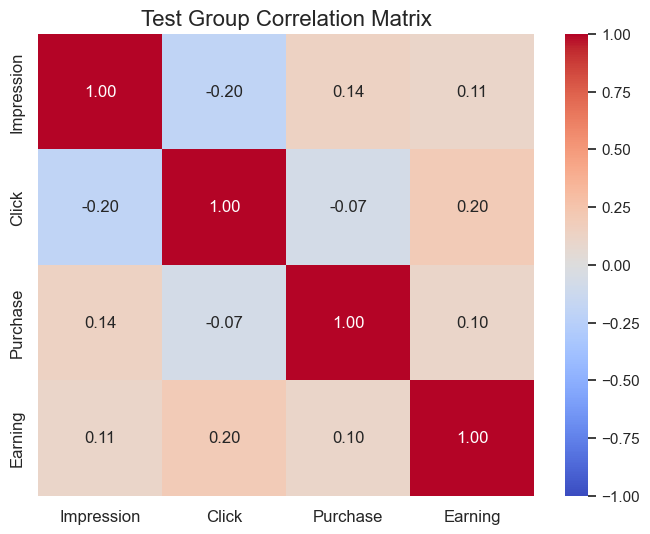

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12}, fmt='.2f')
plt.title('Test Group Correlation Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fl.fig_caption("Test Group Correlation Matrix",
               "This heatmap illustrates the correlation matrix for the Test Group, showing pairwise correlations between variables. The color gradient indicates the strength and direction of correlations, with numerical values annotated for precise interpretation.")

The correlation matrix for the test group reveals that impressions have a weak negative correlation with clicks (-0.20), indicating that more impressions do not necessarily lead to more clicks, and a weak positive correlation with purchases (0.14) and earnings (0.11), suggesting a slight increase in purchases and earnings with more impressions. Clicks show a very weak negative correlation with purchases (-0.07) but a weak positive correlation with earnings (0.20), implying that while clicks do not significantly influence purchases, they have a slight positive impact on earnings. Purchases have weak correlations with impressions (0.14), clicks (-0.07), and earnings (0.10), indicating that purchases are only slightly influenced by these metrics. Overall, earnings display weak positive correlations with impressions (0.11), clicks (0.20), and purchases (0.10), suggesting that while there are slight positive relationships, they are not strong enough to significantly impact ad campaign strategies. These results imply that optimizing ad campaigns requires analyzing additional factors beyond increasing impressions or clicks to effectively boost purchases and earnings.

In [17]:
control_df = control_df.withColumn('Group', F.lit('Control'))
test_df = test_df.withColumn('Group', F.lit('Test'))

combined_df = control_df.union(test_df)

Combining the control and test datasets into a unified DataFrame ensures consistent feature engineering, as techniques like polynomial expansion and scaling require uniform application across the entire dataset. By merging the data, you apply these transformations consistently, providing a solid foundation for model training and evaluation. Additionally, combining the datasets facilitates more effective model training by giving the machine learning algorithms access to a broader and more representative set of examples from both groups. This enhances the model's ability to learn relevant patterns and make accurate predictions.

In [18]:
assembler = VectorAssembler(inputCols=['Impression', 'Click', 'Purchase'], outputCol='features')
combined_df = assembler.transform(combined_df)

Vector Assembler ensures that the features included (Impression, Click, Purchase) are correctly processed and standardized before model training. This step is crucial as it converts raw features into a format suitable for machine learning models.

In [19]:
fl.table_caption("Combined DataFrame Overview",
                 "This table displays the data from the Combined DataFrame, including all relevant columns and their corresponding values. It consolidates information from different sources or conditions for comprehensive analysis.")

combined_df.show()

+----------+-----+--------+-------+-------+--------------------+
|Impression|Click|Purchase|Earning|  Group|            features|
+----------+-----+--------+-------+-------+--------------------+
|     82529| 6090|     665|   2311|Control|[82529.0,6090.0,6...|
|     98050| 3383|     315|   1743|Control|[98050.0,3383.0,3...|
|     82696| 4168|     458|   1798|Control|[82696.0,4168.0,4...|
|    109914| 4911|     487|   1696|Control|[109914.0,4911.0,...|
|    108458| 5988|     441|   1544|Control|[108458.0,5988.0,...|
|     77774| 4462|     520|   2082|Control|[77774.0,4462.0,5...|
|     95111| 3556|     513|   1815|Control|[95111.0,3556.0,5...|
|    106649| 4358|     747|   1965|Control|[106649.0,4358.0,...|
|    122710| 5092|     746|   1652|Control|[122710.0,5092.0,...|
|     79498| 6654|     471|   2456|Control|[79498.0,6654.0,4...|
|     83677| 4273|     386|   2174|Control|[83677.0,4273.0,3...|
|    132781| 5830|     629|   1992|Control|[132781.0,5830.0,...|
|     87939| 3993|     61

In [20]:
combined_df.printSchema()

root
 |-- Impression: integer (nullable = true)
 |-- Click: integer (nullable = true)
 |-- Purchase: integer (nullable = true)
 |-- Earning: integer (nullable = true)
 |-- Group: string (nullable = false)
 |-- features: vector (nullable = true)



Include polynomial features if the relationships are nonlinear.

In [21]:
poly_expansion = PolynomialExpansion(degree=2, inputCol='features', outputCol='poly_features')
poly_df = poly_expansion.transform(combined_df)

The choice of degree 2 for polynomial expansion is reasonable for capturing interaction effects and non-linear relationships between features. Consider experimenting with higher degrees if necessary, but be mindful of the risk of overfitting.

In [22]:
fl.table_caption("Polynomial DataFrame Overview",
                 "This table presents the data from the Polynomial DataFrame, including all relevant columns and their associated values. It provides insights into polynomial features or transformations applied to the data.")

poly_df.show()

+----------+-----+--------+-------+-------+--------------------+--------------------+
|Impression|Click|Purchase|Earning|  Group|            features|       poly_features|
+----------+-----+--------+-------+-------+--------------------+--------------------+
|     82529| 6090|     665|   2311|Control|[82529.0,6090.0,6...|[82529.0,6.811035...|
|     98050| 3383|     315|   1743|Control|[98050.0,3383.0,3...|[98050.0,9.613802...|
|     82696| 4168|     458|   1798|Control|[82696.0,4168.0,4...|[82696.0,6.838628...|
|    109914| 4911|     487|   1696|Control|[109914.0,4911.0,...|[109914.0,1.20810...|
|    108458| 5988|     441|   1544|Control|[108458.0,5988.0,...|[108458.0,1.17631...|
|     77774| 4462|     520|   2082|Control|[77774.0,4462.0,5...|[77774.0,6.048795...|
|     95111| 3556|     513|   1815|Control|[95111.0,3556.0,5...|[95111.0,9.046102...|
|    106649| 4358|     747|   1965|Control|[106649.0,4358.0,...|[106649.0,1.13740...|
|    122710| 5092|     746|   1652|Control|[122710.0,5

In [23]:
# Apply Feature Scaling to ensure that the features are scaled properly.
scaler = StandardScaler(inputCol='poly_features', outputCol='scaled_features')
scaler_model = scaler.fit(poly_df)
scaled_df = scaler_model.transform(poly_df)

StandardScaler confirms that scaling is appropriately applied to the polynomial features to normalize their range. This helps in stabilizing the learning process and improving model performance.

In [24]:
# Apply log transformation to the target variable to handle skewness.
scaled_df = scaled_df.withColumn('log_Earning', log(col('Earning') + 1 ))

Adding a constant of 1 to Earning before applying the logarithm is a good practice to handle cases where earnings might be zero. Ensure that this transformation is suitable for the distribution of earnings in the dataset.

In [25]:
fl.table_caption("Scaled DataFrame Overview",
                 "This table displays the data from the Scaled DataFrame, showing the values after scaling or normalization. It provides insights into how the data has been transformed to a common scale for analysis or modeling.")

scaled_df.show()

+----------+-----+--------+-------+-------+--------------------+--------------------+--------------------+------------------+
|Impression|Click|Purchase|Earning|  Group|            features|       poly_features|     scaled_features|       log_Earning|
+----------+-----+--------+-------+-------+--------------------+--------------------+--------------------+------------------+
|     82529| 6090|     665|   2311|Control|[82529.0,6090.0,6...|[82529.0,6.811035...|[3.81658138027704...|7.7458682297922685|
|     98050| 3383|     315|   1743|Control|[98050.0,3383.0,3...|[98050.0,9.613802...|[4.53435524889631...| 7.463936604468925|
|     82696| 4168|     458|   1798|Control|[82696.0,4168.0,4...|[82696.0,6.838628...|[3.82430435148118...| 7.494986233950533|
|    109914| 4911|     487|   1696|Control|[109914.0,4911.0,...|[109914.0,1.20810...|[5.08300992174594...| 7.436617265234227|
|    108458| 5988|     441|   1544|Control|[108458.0,5988.0,...|[108458.0,1.17631...|[5.01567671172663...|7.3427791893

In [26]:
fl.table_caption("Training Data Sample",
                 "This table displays a sample of the training data, which has been split from the Scaled DataFrame. The sample includes the first five rows, providing a glimpse of the data used for model training.")

train_df, test_df = scaled_df.randomSplit([0.7, 0.3], seed=42)
train_df.limit(5).toPandas()

,Impression,Click,Purchase,Earning,Group,features,poly_features,scaled_features,log_Earning
0,45476,7370,400,1254,Control,"[45476.0, 7370.0, 400.0]","[45476.0, 2068066576.0, 7370.0, 335158120.0, 5...","[2.1030529250260988, 0.43226122875689504, 5.79...",7.134891
1,77774,4462,520,2082,Control,"[77774.0, 4462.0, 520.0]","[77774.0, 6048795076.0, 4462.0, 347027588.0, 1...","[3.596684804973608, 1.2643014603077345, 3.5069...",7.641564
2,80254,3075,531,2101,Control,"[80254.0, 3075.0, 531.0]","[80254.0, 6440704516.0, 3075.0, 246781050.0, 9...","[3.711373239621878, 1.3462172255262264, 2.4167...",7.650645
3,81873,7959,729,1332,Control,"[81873.0, 7959.0, 729.0]","[81873.0, 6703188129.0, 7959.0, 651627207.0, 6...","[3.7862444394991153, 1.4010807828220382, 6.255...",7.195187
4,82068,6609,267,1792,Control,"[82068.0, 6609.0, 267.0]","[82068.0, 6735156624.0, 6609.0, 542387412.0, 4...","[3.795262280126701, 1.4077627441721106, 5.1943...",7.491645


In [27]:
# Train the linear regression model with regularization to predict earnings.
lr = LinearRegression(featuresCol='scaled_features', labelCol='log_Earning', elasticNetParam=0.8)
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

The use of regularization (elasticNetParam=0.8) is appropriate for controlling overfitting. Make sure the regularization parameter is tuned properly based on model performance.

In [28]:
# Evaluate the linear regression model using the test set.
fl.table_caption("Linear Regression Evaluation and Predictions",
                 "This table displays the results of the linear regression model evaluation. It includes the Root Mean Squared Error (RMSE) and R-squared (R2) metrics for the model. The table also shows the linear regression predictions alongside the actual log earnings and the features used in the model.")

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='log_Earning', metricName='rmse')
lr_rmse = evaluator.evaluate(lr_predictions)
lr_r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")
print("Linear Regression Predictions:")
lr_predictions.select('features', 'log_Earning', 'prediction').show()

Linear Regression RMSE: 0.2029164400654901
Linear Regression R2: -0.4404479181954042
Linear Regression Predictions:
+--------------------+------------------+------------------+
|            features|       log_Earning|        prediction|
+--------------------+------------------+------------------+
|[79498.0,6654.0,4...| 7.806696372521179|  7.40691856792011|
|[82529.0,6090.0,6...|7.7458682297922685| 7.512981996021814|
|[83677.0,4273.0,3...| 7.684783943522785| 7.598527605437723|
|[83677.0,7154.0,4...| 7.596392304064196|  7.35291305950031|
|[94139.0,6994.0,5...| 7.360739903058278| 7.398615185220698|
|[94226.0,5256.0,6...| 7.645397699428633| 7.598880135129282|
|[94472.0,5937.0,6...| 7.388946097618437| 7.555832007518115|
|[98050.0,3383.0,3...| 7.463936604468925| 7.684383434215021|
|[101616.0,5324.0,...| 7.688455356549944| 7.693815592090796|
|[105493.0,2190.0,...| 7.655864017616056|7.7858576755745865|
|[106649.0,4358.0,...| 7.583756300707112| 7.755648544039891|
|[110480.0,3585.0,...| 7.69028

In [29]:
# Visualize the predictions and  the linear regression model performance.
lr_predictions_pd = lr_predictions.select('scaled_features', 'log_Earning', 'prediction').toPandas()

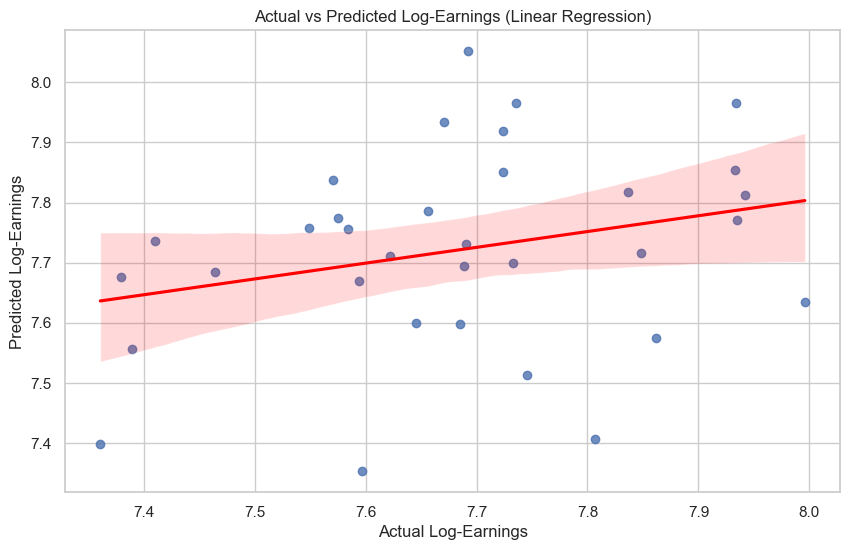

In [30]:
plt.figure(figsize=(10, 6))
sns.regplot(x='log_Earning', y='prediction', data=lr_predictions_pd, line_kws={"color": "red"})
plt.xlabel('Actual Log-Earnings')
plt.ylabel('Predicted Log-Earnings')
plt.title('Actual vs Predicted Log-Earnings (Linear Regression)')
plt.show()

fl.fig_caption("Actual vs Predicted Log-Earnings",
               "This figure presents a scatter plot showing the relationship between actual and predicted log-earnings from the linear regression model. The red line represents the regression line, illustrating how well the predicted values match the actual log-earnings.")

The scatter plot shows the relationship between the actual and predicted log-earnings from a Linear Regression model, with the red shaded area representing the confidence interval. The plot illustrates that the predicted log-earnings (y-axis) generally align with the actual log-earnings (x-axis), with a slight upward trend indicating a positive correlation. However, the dispersion of data points around the regression line suggests that the model does not capture all the variability in the actual log-earnings, implying that while the model has some predictive power, it is not highly accurate. This means that although linear regression can predict log-earnings to some extent, the presence of significant residuals and the wide confidence interval suggest that other factors not included in the model may also be influencing earnings.

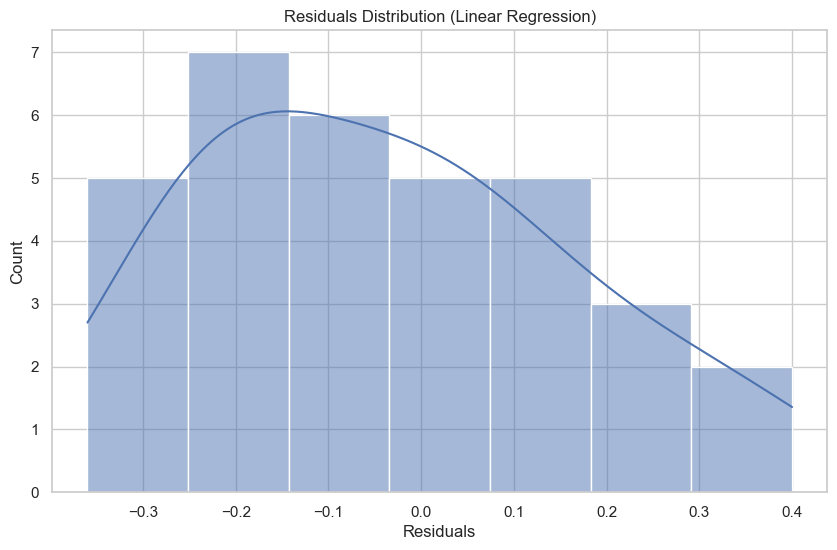

In [31]:
plt.figure(figsize=(10, 6))
residuals = lr_predictions_pd['log_Earning'] - lr_predictions_pd['prediction']
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (Linear Regression)')
plt.xlabel('Residuals')
plt.show()

fl.fig_caption("Residuals Distribution",
               "This figure shows the distribution of residuals from the linear regression model. The histogram, along with the Kernel Density Estimate (KDE) curve, illustrates the spread and density of residuals, which helps assess the model's fit and identify any patterns in the errors.")

The histogram displays the distribution of residuals from a Linear Regression model predicting log-earnings. The residuals, representing the differences between actual and predicted log-earnings, are mostly centered around zero, indicating that the model's predictions are reasonably accurate on average. However, the spread of residuals, ranging approximately from -0.3 to 0.4, suggests that there are instances where the model's predictions deviate significantly from the actual values. The left skewness implies that the model tends to under-predict log-earnings more often than it over-predicts. Overall, while the model performs fairly well, the variability in residuals indicates that it does not fully capture all factors influencing log-earnings, highlighting areas for potential model improvement or the need to incorporate additional predictors.

In [32]:
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='log_Earning')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

In [33]:
fl.table_caption("Decision Tree Model Evaluation and Predictions",
                 "This table presents the evaluation metrics for the decision tree model, including the Root Mean Squared Error (RMSE) and R-squared (R2). It also displays the decision tree predictions along with the actual log earnings and features used in the model.")

dt_rmse = evaluator.evaluate(dt_predictions)
dt_r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})

print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R2: {dt_r2}")
print("Decision Tree Predictions:")
dt_predictions.select('features', 'log_Earning', 'prediction').show()

Decision Tree RMSE: 0.21332509399786037
Decision Tree R2: -0.5920143665829649
Decision Tree Predictions:
+--------------------+------------------+-----------------+
|            features|       log_Earning|       prediction|
+--------------------+------------------+-----------------+
|[79498.0,6654.0,4...| 7.806696372521179|7.491645473605133|
|[82529.0,6090.0,6...|7.7458682297922685|7.626502124050998|
|[83677.0,4273.0,3...| 7.684783943522785|7.631118692334322|
|[83677.0,7154.0,4...| 7.596392304064196|7.396948602621013|
|[94139.0,6994.0,5...| 7.360739903058278|7.396948602621013|
|[94226.0,5256.0,6...| 7.645397699428633|7.866132562092379|
|[94472.0,5937.0,6...| 7.388946097618437|7.626502124050998|
|[98050.0,3383.0,3...| 7.463936604468925|7.838449578262657|
|[101616.0,5324.0,...| 7.688455356549944|7.866132562092379|
|[105493.0,2190.0,...| 7.655864017616056|7.838449578262657|
|[106649.0,4358.0,...| 7.583756300707112|7.866132562092379|
|[110480.0,3585.0,...| 7.690286020676768|7.838449578262

In [34]:
# Visualize the predictions and  the decision tree model performance.
dt_predictions_pd = dt_predictions.select('scaled_features', 'log_Earning', 'prediction').toPandas()

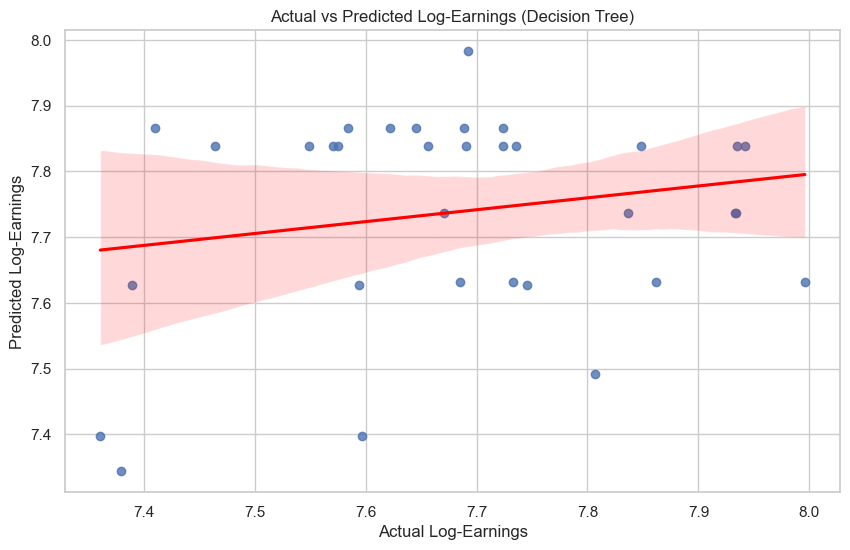

In [35]:
plt.figure(figsize=(10, 6))
sns.regplot(x='log_Earning', y='prediction', data=dt_predictions_pd, line_kws={"color": "red"})
plt.xlabel('Actual Log-Earnings')
plt.ylabel('Predicted Log-Earnings')
plt.title('Actual vs Predicted Log-Earnings (Decision Tree)')
plt.show()

fl.fig_caption("Actual vs Predicted Log-Earnings (Decision Tree)",
               "This figure displays a scatter plot of actual versus predicted log-earnings from the decision tree model. The red line represents the regression line, showing the alignment between the predicted and actual values of log-earnings.")

The scatter plot depicts the relationship between actual and predicted log-earnings from a Decision Tree model, with the red shaded area representing the confidence interval. The predicted log-earnings (y-axis) show some alignment with the actual log-earnings (x-axis), but there is notable variability, as indicated by the wide confidence interval. The spread of data points around the central trend line suggests that the Decision Tree model captures some aspects of the log-earnings but misses others, leading to considerable prediction errors. The funnel shape of the confidence interval, wider at the extremes and narrower in the middle, indicates that the model's predictions are more reliable for mid-range log-earnings but less accurate for very high or low values. This implies that while the Decision Tree has moderate predictive power, it struggles with extreme values, suggesting a need for model refinement or additional features to improve accuracy.

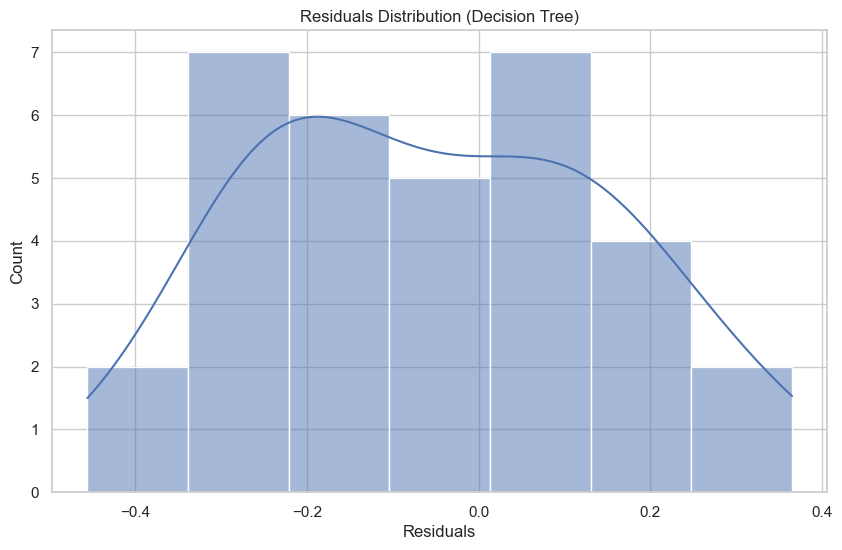

In [36]:
plt.figure(figsize=(10, 6))
residuals = dt_predictions_pd['log_Earning'] - dt_predictions_pd['prediction']
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (Decision Tree)')
plt.xlabel('Residuals')
plt.show()

fl.fig_caption("Residuals Distribution (Decision Tree)",
               "This figure shows the distribution of residuals from the decision tree model. The histogram, along with the Kernel Density Estimate (KDE) curve, illustrates the spread and density of residuals, providing insight into the model's fit and error patterns.")

The histogram presents the residuals distribution for the Decision Tree model predicting log-earnings, with residuals ranging from approximately -0.4 to 0.4. The residuals are relatively evenly spread around zero, suggesting that the model's predictions are fairly balanced between over- and under-prediction. However, the wide spread of residuals indicates a significant level of prediction error, highlighting the model's limitations in accurately capturing the true log-earnings. The presence of notable peaks, particularly at the extremes, implies that the model frequently makes substantial errors in certain cases. This distribution suggests that while the Decision Tree model has some predictive capability, its accuracy is inconsistent, and there may be unaccounted factors or nonlinear relationships affecting the log-earnings that the model fails to address effectively.

In [37]:
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='log_Earning')
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

In [38]:
fl.table_caption("Gradient Boosted Tree Model Evaluation and Predictions",
                 "This table presents the evaluation metrics for the Gradient Boosted Tree (GBT) model, including the Root Mean Squared Error (RMSE) and R-squared (R2). It also displays the GBT predictions along with the actual log earnings and features used in the model.")

gbt_rmse = evaluator.evaluate(gbt_predictions)
gbt_r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})
print("GBT Predictions:")
gbt_predictions.select('features', 'log_Earning', 'prediction').show()
print(f"GBT RMSE: {gbt_rmse}")
print(f"GBT R2: {gbt_r2}")

GBT Predictions:
+--------------------+------------------+------------------+
|            features|       log_Earning|        prediction|
+--------------------+------------------+------------------+
|[79498.0,6654.0,4...| 7.806696372521179| 7.666517031118274|
|[82529.0,6090.0,6...|7.7458682297922685|  7.66147131434599|
|[83677.0,4273.0,3...| 7.684783943522785| 7.522774609330507|
|[83677.0,7154.0,4...| 7.596392304064196| 7.464510695635514|
|[94139.0,6994.0,5...| 7.360739903058278| 7.392288786573014|
|[94226.0,5256.0,6...| 7.645397699428633| 7.925992914371348|
|[94472.0,5937.0,6...| 7.388946097618437|7.6296826959899935|
|[98050.0,3383.0,3...| 7.463936604468925| 7.822389033086947|
|[101616.0,5324.0,...| 7.688455356549944|7.8492059557065295|
|[105493.0,2190.0,...| 7.655864017616056| 7.766890006484207|
|[106649.0,4358.0,...| 7.583756300707112| 7.718023803996187|
|[110480.0,3585.0,...| 7.690286020676768|  7.83275482389361|
|[114341.0,3806.0,...|7.5485559791698735| 7.812133893959376|
|[11782

In [39]:
gbt_predictions_pd = gbt_predictions.select('scaled_features', 'log_Earning', 'prediction').toPandas()

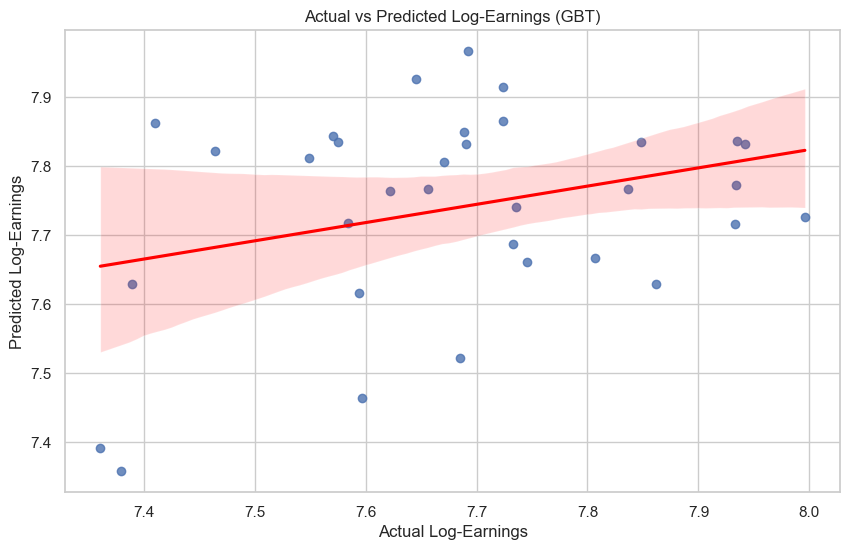

In [40]:
plt.figure(figsize=(10, 6))
sns.regplot(x='log_Earning', y='prediction', data=gbt_predictions_pd, line_kws={"color": "red"})
plt.xlabel('Actual Log-Earnings')
plt.ylabel('Predicted Log-Earnings')
plt.title('Actual vs Predicted Log-Earnings (GBT)')
plt.show()

fl.fig_caption("Actual vs Predicted Log-Earnings (GBT)",
               "This figure displays a scatter plot of actual versus predicted log-earnings from the Gradient Boosted Tree (GBT) model. The red line represents the regression line, illustrating the alignment between the predicted and actual values of log-earnings.")

The scatter plot compares the actual versus predicted log-earnings using a Gradient Boosting Trees (GBT) model, with the red shaded area indicating the confidence interval of the predictions. The points are somewhat dispersed around the diagonal line where the actual values would equal the predicted values, showing that the model's predictions are not perfectly accurate. The broadening of the red shaded area as actual log-earnings increase suggests increasing uncertainty in the predictions for higher log-earnings. The scatter of blue points, some significantly deviating from the diagonal, further highlights the prediction errors, indicating that while the GBT model captures some trends in the data, its accuracy diminishes for certain ranges of log-earnings, possibly due to unaccounted variables or the model's inherent limitations in capturing complex relationships within the data.

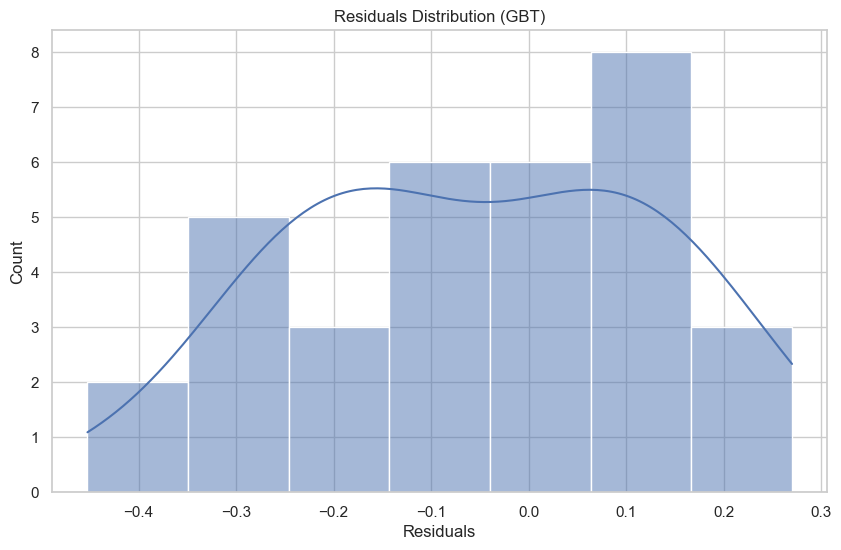

In [41]:
plt.figure(figsize=(10, 6))
residuals = gbt_predictions_pd['log_Earning'] - gbt_predictions_pd['prediction']
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (GBT)')
plt.xlabel('Residuals')
plt.show()

fl.fig_caption("Residuals Distribution (GBT)",
               "This figure shows the distribution of residuals from the Gradient Boosted Tree (GBT) model. The histogram, along with the Kernel Density Estimate (KDE) curve, illustrates the spread and density of residuals, providing insight into the model's fit and error patterns.")

The histogram of residuals for the Gradient Boosting Trees (GBT) model predicting log-earnings shows the distribution of prediction errors, with residuals ranging from approximately -0.4 to 0.3. The distribution is somewhat symmetric around zero, indicating a balanced spread of over- and under-predictions. However, the presence of several residuals at both extremes (-0.4 and 0.3) suggests that the model occasionally makes substantial errors. The most frequent residuals are closer to zero, indicating that many predictions are relatively accurate. Nonetheless, the spread and notable peaks at the extremes highlight the model's limitations, suggesting it struggles to capture all the nuances in the data, possibly due to unaccounted variables or complex, nonlinear relationships affecting log-earnings that the model does not adequately address.

[ref]: #top
[Back to Table of Contents][ref]

<a name="res_dis"></a>
## Results and Discussions
In this section, we present the results of the predictive modeling analysis.
***

The analysis provides three integrated predictive models: linear regression, decision tree regression, and gradient-boosted trees (GBT) regression, based on impressions, clicks, and purchases. **The Root Mean Squared Error (RMSE) and R-squared (R2) were used to assess the models' accuracy and fit. The data exploration circulates to analyze and understand data patterns and their relationship to player attributes and performance.**

In the data exploratory analysis, the evaluation emerges by distributing control and test group variables, including its correlation matrix, to assess relationships among metrics. The correlation matrix for the *control group* shows that Impression is weakly positively correlated with Purchase (0.21) and Earning (0.11) but moderately negatively correlated with Click (-0.31). Click has a moderate negative correlation with Earning (-0.36). This implies that while **improving impressions may somewhat increase sales and revenues, clicks do not majorly impact these metrics.** Having more impressions indicates that numerous individuals view the product, thereby increasing the possibility of Purchase. Yet the association is weak; other variables are likely to have a more significant impact on purchasing decisions. Likewise, with regard to purchases, **more impressions might result in slightly larger revenue as more prospective purchasers are exposed to the goods. However, the weak correlation suggests that perceptions alone do not significantly impact wages.** 

Meanwhile, the correlation matrix of the *test group* revealed in Impressions has a weak negative correlation with clicks (-0.20) and weak positive correlations with purchases (0.14) and earnings (0.11). Following that, Clicks have a very weak negative correlation with purchases (-0.07) and a weak positive correlation with earnings (0.20). Purchases have weak correlations with impressions (0.14), clicks (-0.07), and earnings (0.10). Lastly, Earnings show weak positive correlations with impressions (0.11), clicks (0.20), and purchases (0.10). Hence, the test group correlation matrix shows **weak correlations, suggesting that simply increasing impressions or clicks may not significantly boost purchases or earnings.** 

The analyzation of data patterns and the relationship of attributes and performance views several factors in recognizing sufficient influences towards productive purchases. Moreover, this analysis performs multiple machine learning models to predict the log-transformed earnings based on impressions, clicks, and purchases. 

In this part of results and discussion, the actual vs predicted log-earning are first to be analyzed then followed by the residuals distribution and on which machine learning best perform in predicting log-earning to provide a better implication to estimate the earnings based on the metrics. 

**Linear Regression Model**

    The actual vs predicted log-earnings shows that the scatter figure reveals a minor positive correlation between actual and expected log-earnings, with the red line being the regression line. Additionally, the dispersion of data points around the regression line indicates variability and departures from anticipated values, exposing some errors in the model's predictions. This suggests that the model may not account for all factors driving log-earnings.

    The residual distribution histogram reveals a clear visual picture of how the model's predictions match the actual data. The clustering suggests that the model's predictions are typically accurate, implying a good match for the data. When the residuals are mostly in this range, it indicates that the differences between anticipated and observed values are minimal. This suggests that the model might fail to account for all factors driving log-earnings. 

**Decision Tree Model**

    The actual vs predicted log-earnings shows that the data points show a substantial dispersion, showing that the forecasts are less reliable at these extreme ranges. As one approaches the spectrum's extremities, this red highlight emphasizes a greater range of projected values. The growth of this red band at the lower and upper ends highlights the large prediction mistakes that occur in these places. However, the model may perform relatively well for the bulk of the data, but its accuracy decreases when analyzing numbers at the extremes. The scatter plot effectively conveys the degree of uncertainty and variability in predictions, particularly illustrating that the confidence in predictions decreases significantly for extreme values of log-earnings. 
 
    The residual distribution histogram deploys that it is skewed to the left which means that the model overestimates log-earnings for certain data points. The Decision Tree model's errors are partially evenly distributed near zero. This suggests that, on average, the model's estimates are free of systematic bias. However, the heights of the extreme ends suggest that the model has made considerable errors in certain cases, which may indicate it is not fully capturing some aspects of the data.

**Gradient Boosted Trees (GBT) Regressor**

    The actual vs predicted log-earnings appears that the scatter plot shows an increasing trend, indicating some degree of predictive power. However, the dispersion of points reveals discrepancies between actual and expected values. The considerable departures of some projected values from the diagonal line emphasize the model's reliability limits, indicating that the GBT model identifies some trends but problems with specific log-earnings ranges.

    The residual distribution histogram showcases the distribution of residuals, with some peaks indicating places where the model's predictions are particularly accurate. The histogram has a slightly symmetric distribution near zero, indicating a balanced efficiency between over- and under-prediction. This symmetry indicates that the model's performance is generally balanced, lacking consistent bias. 

Accordingly, within the three machine learning models: Linear Regression, Decision Tree Regressor, and Gradient Boosted Trees (GBT) Regressor, **the Gradient Boosted Trees (GBT) Regressor is the most successful model for estimating profits**. As it combines numerous weak areas to enhance accuracy, and is capable of modeling complicated non-linear connections, and performs better with additional data. Linear Regression gives an **accurate log-earnings overview with considerable variability, yet it overlooks influences of log-earnings**. The Decision Tree model faces a **challenge in complex relationships and variability in the data but still manages to deliberate rational predictions**. Therefore, the GBT appears to offer a development over the Decision Tree model that captures trends for higher log-earnings and significant errors. 


[ref]: #top
[Back to Table of Contents][ref]

<a name="conc"></a>
## Conclusion and Recommendations
In this section, we will summarize our findings and provide recommendations based on the analysis performed.
***

The exploratory data analysis indicates that in both the control and test groups, there are generally weak relationships between impressions, clicks, purchases, and earnings. Although impressions had a slight positive effect on sales and profits in the control group, they are much more strongly negatively correlated with clicks, which also negatively affect earnings. This suggests that increasing impressions might have a minor positive impact on sales and revenue, but clicks have a lesser influence on these metrics. The correlation matrix for the test group shows that neither impressions or clicks significantly influence purchases or profits, suggesting that these factors may not be the primary drivers of financial outcomes. With the viewing of the weak correlation matrix in the metrics, it apprehends that **there are possible potential factors that confides the increasing and decreasing of purchases and earnings. These factors can be associated with consumers' personal behavior, click baits, error in clicking, or even last minute decision planning of purchases.** 

Moreover, in the essence of the three employed modeling, the analysis of actual vs. predicted log-earnings and residual distributions in the three machine learning models, Linear Regression, Decision Tree Regressor, and Gradient Boosted Trees (GBT) Regressor has shown rising advantages and implications towards predicting earnings or log-earnings. The Linear Regression model indicates a slight positive correlation and mostly accurate predictions, but it displays variability and does not account for all factors influencing log-earnings. The Decision Tree model, on the other hand, has significant prediction errors at the extremes and tends to overestimate log-earnings for some data points, though it does not show a consistent bias. Conversely, the **GBT Regressor stands out, successfully identifying trends and delivering balanced performance without persistent bias.**

Based on the comparative analysis of predictive models—namely Linear Regression, Decision Tree Regression, and Gradient Boosted Trees (GBT) Regressor—the GBT model shows superior accuracy in capturing complex, non-linear relationships within the dataset. To further enhance the precision of earnings forecasts, it is recommended to integrate additional explanatory variables that may affect earnings, such as detailed customer demographics and behavioral patterns. Additionally, applying rigorous cross-validation techniques and optimizing hyperparameters for the GBT model will improve its reliability and performance, thereby yielding more precise predictions of log-earnings.

[ref]: #top
[Back to Table of Contents][ref]

<a name="refe"></a>
## References
***

Yılmaz, D. (2023, October 10). Optimizing ad bidding: Facebook’s A/B test story. Kaggle. https://www.kaggle.com/datasets/furth3r/facebook-ab-test-of-bidding-feature?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR0KSdhxJak6zem52GtLSLJP_Oys5-Zcx1PzaAekiI5rEtKMKjJhxIpv9j0_aem_lXHvjwx2kc2eSm7Zwmp92g

[ref]: #top
[Back to Table of Contents][ref]